In [14]:
import pandas as pd
import os
import sys 
# sys.path.append("/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/ml_chat")
sys.path.insert(0,"/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/")


from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
import functools
from typing import TypedDict, Annotated, Sequence, Tuple, Optional, List
import operator
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS, Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores.faiss import DistanceStrategy


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
sys.path.insert(0,"/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/")

from ml_chat.agents.workflow import MultilingualChatWorkflow

user_list = [('roshan','english'),('shweta','french')]
data_directory = '/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/ml_chat/playground/data'

app = MultilingualChatWorkflow(user_list=user_list, knowledge_base_directory= data_directory)

Number of valid files (.pdf, .docx, .doc) in the directory: 3


In [10]:
app.send_message('roshan','Hey! Did you check in with Aaron on the status of the deployment?')

content='Hey! Did you check in with Aaron on the status of the deployment?' response_metadata={'finish_reason': 'stop'} id='run-5467de4b-e91c-404f-b762-755f3d58f5ee-0'
Within send_text. output type : <class 'langgraph.pregel.io.AddableValuesDict'>


In [11]:
app.send_message('shweta',"Oui, il a dit qu'il serait déployé demain")

content='Yes, he said he would be deployed tomorrow' response_metadata={'finish_reason': 'stop'} id='run-f3208023-0f34-4ee6-adf2-b7908a7083d5-0'
Within send_text. output type : <class 'langgraph.pregel.io.AddableValuesDict'>


In [231]:
app.send_message('roshan','Aya, What is the full form of SVM?')

content='Aya, What is the full form of SVM?' response_metadata={'finish_reason': 'stop'} id='run-20ed5846-ee40-4ce0-8774-94cad78da449-0'
Within send_text. output type : <class 'langgraph.pregel.io.AddableValuesDict'>


In [232]:
app.send_message('roshan','I heard somewhere that the new models are going to be run on 8x A100 GPUs, which have a total memory of 500 GB.')


content='I heard somewhere that the new models are going to be run on 8x A100 GPUs, which have a total memory of 500 GB.' response_metadata={'finish_reason': 'stop'} id='run-d7373482-cb06-4d42-bdb2-0e5062efaea4-0'
Within send_text. output type : <class 'langgraph.pregel.io.AddableValuesDict'>


In [233]:
app.send_message('roshan','Aya, can you save the previous message to the knowledge base?')


content='Aya, can you save the previous message to the knowledge base?' response_metadata={'finish_reason': 'stop'} id='run-ec834bda-f2c5-4836-845d-142de7d20e43-0'
Within send_text. output type : <class 'langgraph.pregel.io.AddableValuesDict'>


In [234]:
app.send_message('shweta','अया, नए मॉडल की कुल मेमोरी कितनी है?')

content='Aya, what is the total memory of the new model?' response_metadata={'finish_reason': 'stop'} id='run-22d426c1-ef99-4f78-a35e-4296e4647a31-0'
Within send_text. output type : <class 'langgraph.pregel.io.AddableValuesDict'>


In [12]:
app.user_agents['roshan']['agent'].chat_history

[roshan | Hey! Did you check in with Aaron on the status of the deployment?,
 shweta | Yes, he said it would be deployed tomorrow.]

In [13]:
app.user_agents['shweta']['agent'].chat_history

[roshan | Bonjour ! Avez-vous vérifié avec Aaron l'état du déploiement ?,
 shweta | Oui, il a dit qu'il serait déployé demain]

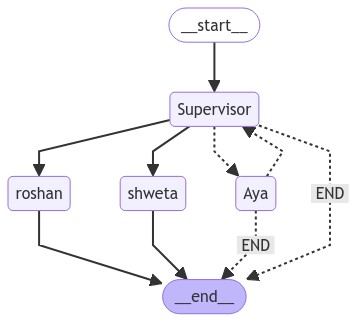

In [240]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        app.app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Test Case 2

In [35]:
sys.path.insert(0,"/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/")

from ml_chat.agents.workflow import MultilingualChatWorkflow

user_list = [('roshan','english'),('shweta','hindi'),('mahid','spanish')]
data_directory = '/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/ml_chat/playground/data'

app = MultilingualChatWorkflow(user_list=user_list, knowledge_base_directory= data_directory, llm = 'Anthropic')

Number of valid files (.pdf, .docx, .doc) in the directory: 3


In [36]:
app.send_message('roshan','Hi!')

Within roshan english| Hi!
Within shweta hindi| नमस्ते!
Within mahid spanish| ¡Hola!
Within send_text. output type : <class 'langgraph.pregel.io.AddableValuesDict'>


In [37]:
app.send_message('mahid','hola!')

Within mahid spanish| hola!
Within shweta hindi| नमस्ते!
Within roshan english| Hello!
Within send_text. output type : <class 'langgraph.pregel.io.AddableValuesDict'>


In [38]:
app.user_agents['roshan']['agent'].chat_history

[roshan | Hi!, mahid | Hello!]

In [39]:
app.user_agents['shweta']['agent'].chat_history

[roshan | नमस्ते!, mahid | नमस्ते!]

In [40]:
app.user_agents['mahid']['agent'].chat_history

[roshan | ¡Hola!, mahid | hola!]

### Supervisor Agent Prompt Testing

In [51]:
SUPERVISOR_AGENT_PROMPT = """
You are a supervisor tasked with managing the chat messages with Aya, an AI assistant. Given a chat
message, identify whether the message was directed to Aya and if so, what was its intention. 

Respond with one of the below 3 options : 
Aya_Query : Output this is the message is asking Aya to answer a question
Aya_Save : Output this is the message asks Aya to save a peice of information to the knowledge base
User : Output this if the message doesnt address Aya

Chat Message : {message}
"""

In [54]:
message = 'Aya, can you tell me the capital of India?'
llm.invoke(SUPERVISOR_AGENT_PROMPT.format(message = message))

AIMessage(content='Aya_Query', response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 123, 'total_tokens': 125}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-34e54676-79b2-4721-9c4d-2ca8d205462b-0')

In [60]:
message = 'Aya, is it possible to save Donald Trump'
llm.invoke(SUPERVISOR_AGENT_PROMPT.format(message = message))

AIMessage(content='Aya_Query', response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 122, 'total_tokens': 124}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-abff7be2-2c8d-45b8-8485-ccf0203b64a3-0')

In [67]:
def router(state, sender, dest1, dest2):
    last_message = state["messages"][-1]
    if last_message.sender == sender:
        return dest1
    else:
        return dest2
    

In [82]:
out = partial(router, sender = "Aya", dest1 = 'End', dest2 = "Aya")

In [69]:
out

functools.partial(<function router at 0x1234b3ce0>, sender='Aya', dest1='End', dest2='Aya')

In [70]:
out('dfd')

'Aya'

In [81]:
from langchain_core.runnables.base import (
    Runnable,
    RunnableConfig,
    RunnableLambda,
    RunnableLike,
    RunnableParallel,
)

In [84]:
if isinstance(out, Runnable):
    print("df")

### Retriever Testing

In [133]:
from langchain_community.document_loaders import PyPDFLoader, TextLoader

In [135]:
valid_extensions = ['.pdf','.txt']
valid_files = [file for file in path.iterdir() if file.is_file() and file.suffix.lower() in valid_extensions]

In [136]:
valid_files = valid_files[2:]

[PosixPath('/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/ml_chat/playground/data/user_data.txt'),
 PosixPath('/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/ml_chat/playground/data/user_file.txt'),
 PosixPath('/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/ml_chat/playground/data/machine_learning_basics.pdf'),
 PosixPath('/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/ml_chat/playground/data/2024_eng.pdf')]

In [140]:
docs = []
for file in valid_files : 
    doc_data = PyPDFLoader(path / file).load()
    docs += doc_data

In [141]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splits = text_splitter.split_documents(docs)

In [142]:
store = FAISS.from_documents(splits, OpenAIEmbeddings(), distance_strategy=DistanceStrategy.COSINE)

In [143]:
retriever = store.as_retriever(search_kwargs={"k": 3})

In [145]:
store.index_to_docstore_id

{0: '1ef6aec8-96a5-4846-ab9b-96893fa041d4',
 1: 'c2b4bc21-062a-4735-ade7-5f58e84163b0',
 2: '620594b4-aff4-4300-aa77-de2386d98035',
 3: 'c1f92e56-f896-4479-992e-159c2ab9df09',
 4: '24ed04f2-1350-4ffd-9173-9bbdd900e1ad',
 5: 'fe894617-87de-4883-a093-a1ad8d5bc5d2',
 6: '84df06c8-961b-4707-b7b3-ab7e24266837',
 7: 'ead11233-4878-42df-891d-86d759248cff',
 8: '7443d96b-0fe3-4421-9248-5aa47a7176f5',
 9: '93674bda-3079-4201-9a0e-f3ebd051570d',
 10: '1f6a5218-e240-4c16-9004-2caac418fccc',
 11: '415cd6fc-2d7b-4be9-84bf-86600a334a3b',
 12: '347f33bf-4e87-4c33-89b6-e24c10ae18b8',
 13: '58fe5d09-a1f1-4399-98b6-2064173e1e98',
 14: 'd0f55789-4b85-49e3-921a-fcc24f16948e',
 15: '5882fdea-fe52-43d3-851e-c8ad4f7edcba',
 16: '56fb8b65-5eeb-4265-8541-98d26ef0548e',
 17: '651e10b0-fffc-4fc3-a95b-e67928d5dac2',
 18: '2a1ac975-fb3c-4b86-bef4-93c99eda6947',
 19: '4877a23a-8d6f-439c-984f-e1d45f72756f',
 20: '7d6ab7f1-54ea-4639-bf36-e876927b58d2',
 21: 'c4bd3fc0-30b4-4f24-b059-621993ab2fde',
 22: '9ba39e89-efff-

In [152]:
store.add_texts(['Capital of India is new delhi. new delhi was founded in 1728. Gave new status to mughal kings'])

['377f13e5-a852-4750-9116-b0205429724e']

In [153]:
retriever.invoke("What is the capital of India")

[Document(page_content='Capital of India is new delhi. new delhi was founded in 1728. Gave new status to mughal kings'),
 Document(metadata={'source': '/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/ml_chat/playground/data/machine_learning_basics.pdf', 'page': 16}, page_content='SRINIVAS BANGALORE\nDIRECTOR OF RESEARCH AND TECHNOLOGY, INTERACTIONS\nDr. Srinivas Bangalore is currently the Director of Research and Technology at \nInteractions. After receiving his PhD in Computer Science from The University of \nPennsylvania, he became a Principal Research Scientist at AT&T Labs—Research. \nDr. Bangalore has worked on many areas of Natural Language Processing including \nSpoken Language Translation, Multimodal Understanding, Language Generation'),
 Document(metadata={'source': '/Users/roshansk/Documents/GitHub/Multilingual-Chatbot/ml_chat/playground/data/2024_eng.pdf', 'page': 1}, page_content='smallest possible value of c.\nLanguage: English Time: 4 hours and 30 minutes.\nEach pro

## Translation tester

In [24]:
USER_SYSTEM_PROMPT2 = """You are a Hindi translator, translating a conversation between work colleagues. Translate the message provided by the user into Hindi. 

    Obey the following rules : 
    1. Only translate the text thats written after 'Message:' and nothing else
    2. If the text is already in Hindi then return the message as it is.
    3. Return only the translated text
    4. Ensure that your translation uses formal language

    Message:
    {message}
"""

prompt = ChatPromptTemplate.from_template(USER_SYSTEM_PROMPT2)

In [23]:
llm = ChatOpenAI(model="gpt-4o", streaming=True, temperature = 0.0)

In [25]:
chain  = prompt | llm

In [28]:
chain.invoke({'message':'hola!'})

AIMessage(content='नमस्ते!', response_metadata={'finish_reason': 'stop'}, id='run-859ad45f-1c8c-44c1-bab4-28f1deda75de-0')